# Salary Predictions Based on Job Descriptions

# Step 2: Discover

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
import sys
sys.path.insert(0, './scripts')
from helpers import load_data, mean_squared_error, find_outliers
from NaiveModel import NaiveModel
from Preprocessing import Preprocessing

## Obtaining the Data

In [17]:
#load the data into a Pandas dataframe
path = './raw_data/'
files = ['train_features.csv', 'train_salaries.csv']

train_features = load_data(path, files[0], verbose=True)

------------------------------train_features shape------------------------------
                                  (1000000, 7)                                  
-------------------------train_features's column types--------------------------
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object
-------------------------train_features first five rows-------------------------
                 companyId         jobType       degree      major industry  \
jobId                                                                         
JOB1362684407687    COMP37             CFO      MASTERS       MATH   HEALTH   
JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE      WEB   
JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   HEALTH   
JOB1362684407690    COMP38         MANAGER     DOCTORAL  

Categorical Ordinal:
* jobType
* degree

Categorical Nominal:
* companyId
* major
* industry

Numerical Continuous:
* milesFromMetropolis
* yearsExperience

In [18]:
train_salaries = load_data(path, files[1], verbose=True)

------------------------------train_salaries shape------------------------------
                                  (1000000, 1)                                  
-------------------------train_salaries's column types--------------------------
salary    int64
dtype: object
-------------------------train_salaries first five rows-------------------------
                  salary
jobId                   
JOB1362684407687     130
JOB1362684407688     101
JOB1362684407689     137
JOB1362684407690     142
JOB1362684407691     163


The features and target variable have the same number of rows which is a good sign that there won't be missing data.

In [31]:
train_merged = train_salaries.merge(train_features, right_on = 'jobId', left_on = 'jobId')
train_merged.shape

(1000000, 8)

The shape is retained during the merge, so there was a salary for every job posting.

In [20]:
train_merged.head()

,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobId,,,,,,,,
JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


## Cleaning the Data

In [21]:
# Ensuring the primary key is unique 
assert(train_merged.index.duplicated().sum() == 0)

All of the *jobId*s are in fact unique, so we can treat each row as a completely separate instance. If there were repeats, then I would further investigate the repeated ids to see if they all the information stayed consistent between the multiple postings and proceeded from there. 

In [22]:
train_merged.isnull().sum()

salary                 0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

There are no missing values in the data set as is. For the continuous variables *yearsExperience* and *milesFromMetropolis* I would have replaced the null values with the mean or median of the respective data depending on the actual distribution. For the categorical columns, I would have most likely had to remove the rows or columns containing null values a long as it was not a significant amount of loss.

I will note that there is a common value of *NONE* in the *major* and *degree* columns. This is not meant to specify the python "None" object. Rather, it is specifying that there is no specific major or degree requirement for that job posting.

## Exploring the Data

Text(0.5, 1.0, 'Histogram of Salaries')

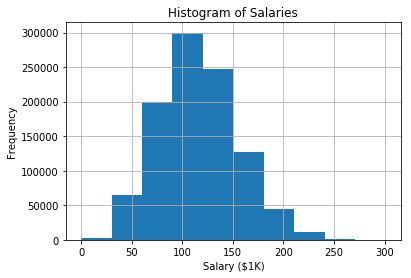

In [9]:
fig, ax = plt.subplots()
train_merged.salary.hist(ax=ax)
ax.set_xlabel('Salary ($1K)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Salaries')

The distribution of salaries is fairly normal with a slight right skew which is to be expected when there is a lower bound and no upper bound. I'll take a look at the distribution a little more closely to see if there are any statistical outliers (defined by being larger than 1.5 * Interquartile Range). I'll use this range to create areas in which I want to investigate.

Number of outliers: 7122


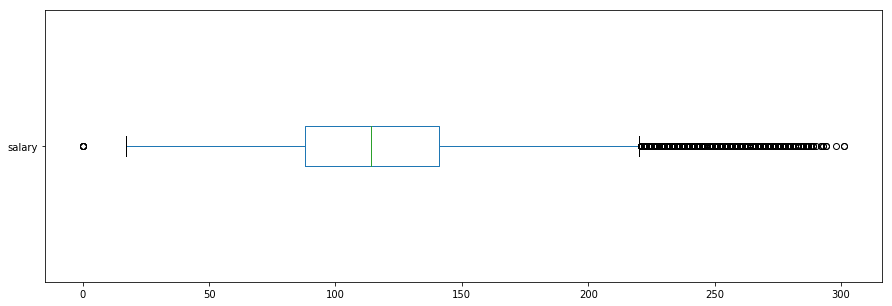

In [32]:
# Exploring salary distribution more
fig, ax = plt.subplots(figsize=(15, 5))
train_merged.salary.plot.box(vert=False, ax=ax)

lower, upper = find_outliers(train_merged.salary)
lower_mask = (train_merged.salary < lower)
upper_mask = (train_merged.salary > upper)

print(f'Number of outliers: {train_merged[lower_mask | upper_mask].shape[0]}')

There appears to be a few postings with a salary of 0. I'll remove those immediately since they are obviously going to be typos.

The rest of the outliers are on the upper end. These could generally be justified since there isn't generally an upper bound on how much a single person could make at a company. Due to time constraints, I will be deferring a further investigation and I will be opting to remove the outliers as they will invariably hurt the results of any model. A CEO with the same experience in a Midwest Metropolitan area will certainly make less than the same CEO position in the Bay Area, and I cannot take that into account. 

In [33]:
train_merged = train_merged[~(upper_mask | lower_mask)]
train_merged.shape

(992878, 8)

#### Exploring the Data: Feature Importance
To help give me a rough idea on how important various features are to building an accurate model, I will be making a naive model from the preprocessed training data with ordinal columns ranked as seen below. The rest of the categorical columns are dummied properly, and no other columns are added in preprocessing. I've also added a column called *noise* which just randomly assigns a row either a 1 or a 0. If a feature is ranked lower than *noise*, then it will most likely hurt my model by overfitting to a signal that is worse than noise.

In [34]:
from sklearn.ensemble import RandomForestRegressor
from Preprocessing import Preprocessing

target = ['salary']
features = [x for x in train_merged.columns if x not in target]
ordinal_cols = {'jobType': ['JANITOR', 'JUNIOR', 'SENIOR', 'MANAGER', 'VICE_PRESIDENT', 'CFO', 'CTO', 'CEO'],
                'degree': ['NONE', 'HIGH_SCHOOL', 'BACHELORS', 'MASTERS', 'DOCTORAL']
               }

p = Preprocessing(ordinal_cols=ordinal_cols, cols_to_filter=['companyId'])
baseline_features = p.fit_transform(train_merged.loc[:, features])

#To see if features can beat out just random noise
baseline_features['noise'] = np.random.randint(2, size=baseline_features.shape[0])

In [35]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)

rf.fit(baseline_features, train_merged.loc[:, target].values.ravel())

importance = rf.feature_importances_

In [38]:
important = pd.DataFrame({'Importance': importance, 
                          'Feature': baseline_features.columns
                         }
                        )

random = important.loc[(important.Feature=='noise'), 'Importance'].values[0]

important = important[important.Importance >= random].sort_values('Importance', ascending=False)

Text(0.5, 1.0, 'Features More Important than Noise')

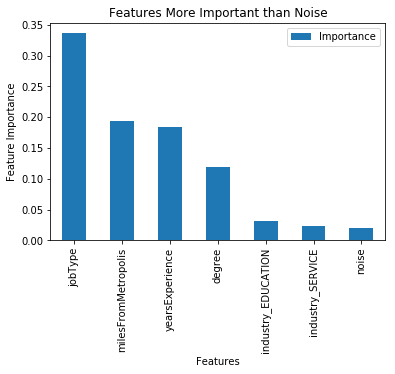

In [39]:
ax = important.plot.bar(x='Feature', y='Importance')

ax.set_ylabel('Feature Importance')
ax.set_xlabel('Features')
ax.set_title('Features More Important than Noise')

It appears that the *major*, *industry*, and *companyId* columns don't seem to add much to the Random Forest model. I might be able to combine them in a way to get more information from them.

### Exploring the Data: Categorical Columns

I'll take a brief look at the categorical columns to see if any can be removed from the start, then take a deeper dive into the remaining columns

In [40]:
categorical_cols = [x for x in train_merged.columns if train_merged[x].dtype == object]
print(categorical_cols)

['companyId', 'jobType', 'degree', 'major', 'industry']


In [41]:
train_merged[categorical_cols].nunique()

companyId    63
jobType       8
degree        5
major         9
industry      7
dtype: int64

*companyId* has a much higher cardinality than the rest of the categorical columns, so I will look at how the salaries vary between the companies separately.

Text(0.01, 0.9, 'Standard Deviation: 0.329')

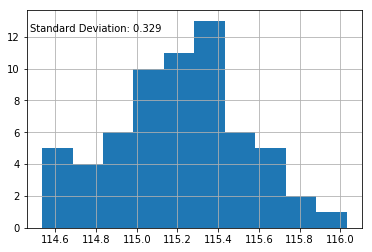

In [42]:
fig, ax = plt.subplots()
companyId_means = train_merged.groupby('companyId').salary.mean()

companyId_means.hist(ax=ax)
plt.sca(ax)
plt.text(s=f'Standard Deviation: {companyId_means.std():.3f}', x=0.01, y=.9, transform=ax.transAxes)

Just as expected with the regressor, the salary doesn't vary much between company's posting. This means it will be a poor distinguisher between data points, and ultimately, will not provide any information when making a regression model.

In [43]:
categorical_cols.remove('companyId')

Average salary broken up by each categorical variable


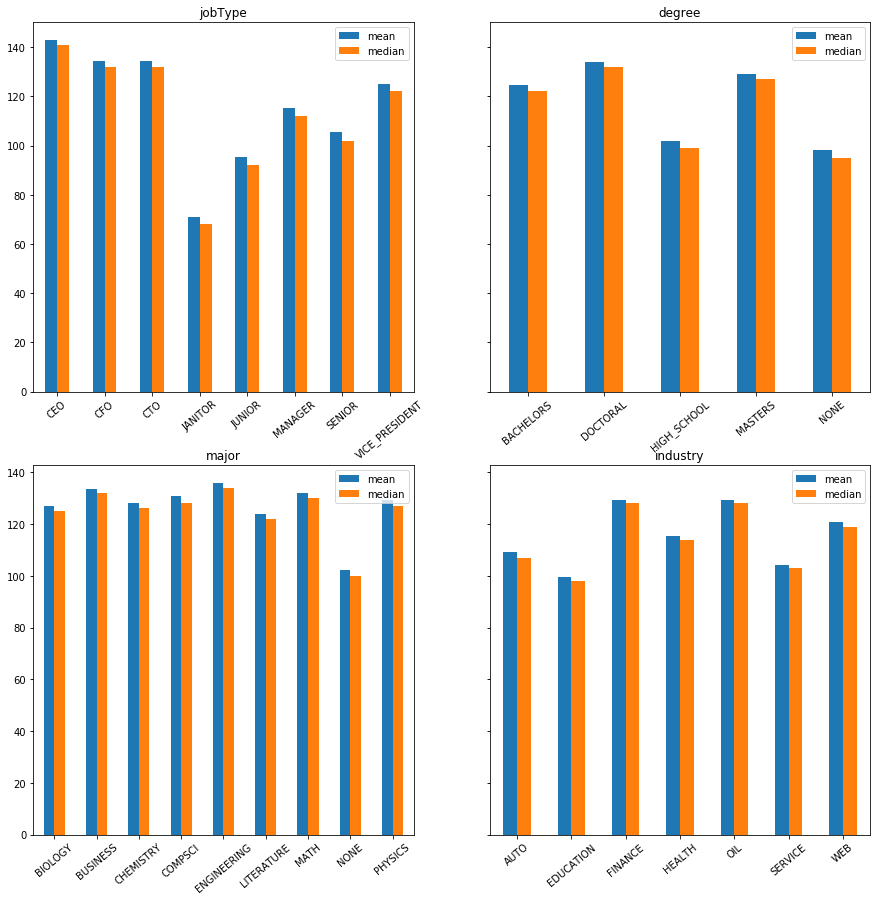

In [44]:
print('Average salary broken up by each categorical variable')

n = len(categorical_cols)
fig, ax = plt.subplots(round(n/2), 2, figsize=(15, 12), sharey='row')

row = 0
col = 0
count = 0

for row in range(round(n/2)):
    for col in range(2):
        mean = train_merged.groupby(categorical_cols[count])['salary'].agg(['mean', 'median'])
        # median = train_merged.groupby(categorical_cols[count])['salary'].mean()
        plt.sca(ax[row][col])
        mean.plot.bar(ax=ax[row][col])
        # plt.bar(height=median, x=mean.index, label='Median')
        #plt.text(s=f'Standard Deviation: {mean.std():.2f}', x=.55, y=.95, transform=ax[row][col].transAxes)
        plt.xticks(rotation=40)
        plt.xlabel('')
        plt.subplots_adjust(bottom=.05, top=.99)
        plt.title(categorical_cols[count])
        plt.legend()
        count += 1

The features *industry* and *major* average salaries don't vary nearly as much as *jobType* and *degree* average salary. We might not be able to learn as much information from them, and I'll keep it in mind when seeing if I want to do feature engineering.

*companyId* barely varies based on the mean for each company. Its standard deviation is an order of magnitude lower than the rest of the categorical data. I don't believe that it will add anything to the models, and it might contribute to overfitting in the worst case scenario. I will be removing *companyId* from any test and training data including scripts that will be utilized in the final pipeline.

In [45]:
train_merged.drop('companyId', axis=1, inplace=True)

In [46]:
for col in train_merged[categorical_cols].columns:
    print(f"----Column: {col}----")
    print(train_merged[col].value_counts())

----Column: jobType----
SENIOR            125820
JANITOR           124971
MANAGER           124903
VICE_PRESIDENT    124631
JUNIOR            124572
CTO               123557
CFO               122873
CEO               121551
Name: jobType, dtype: int64
----Column: degree----
NONE           236645
HIGH_SCHOOL    236621
BACHELORS      174055
MASTERS        173176
DOCTORAL       172381
Name: degree, dtype: int64
----Column: major----
NONE           531471
LITERATURE      58339
CHEMISTRY       58306
BIOLOGY         57857
PHYSICS         57779
COMPSCI         57680
BUSINESS        57356
ENGINEERING     57106
MATH            56984
Name: major, dtype: int64
----Column: industry----
EDUCATION    142706
AUTO         142616
SERVICE      142439
HEALTH       142124
WEB          141925
FINANCE      140666
OIL          140402
Name: industry, dtype: int64


*jobType* and *industry* are fairly even in their spread, but there is a large disproportion in the *major* column where NONE is a majority of the majors. The combination of HIGH_SCHOOL and NONE almost make up a majority in the *degree* column. I'll investigate these further.

#### Exploring the Data: major NONE

count    531471.000000
mean        102.370826
std          35.783459
min          17.000000
25%          76.000000
50%         100.000000
75%         126.000000
max         220.000000
Name: salary, dtype: float64
count    992878.000000
mean        115.213149
std          37.514237
min          17.000000
25%          88.000000
50%         113.000000
75%         140.000000
max         220.000000
Name: salary, dtype: float64


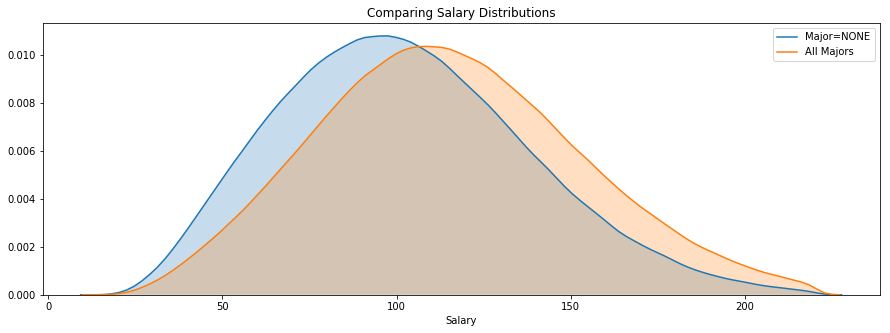

In [47]:
major_none = train_merged[train_merged.major=='NONE']
fig, ax = plt.subplots(figsize=(15,5))

ax = sns.kdeplot(major_none.salary, shade=True, label='Major=NONE')
ax = sns.kdeplot(train_merged.salary, shade=True, label='All Majors')
ax.set_xlabel('Salary')
ax.set_title('Comparing Salary Distributions')

print(major_none.salary.describe())
print(train_merged.salary.describe())

The distributions are quite similar to each other and have quite the large span. I need to find out what NONE major is to extract more information in a new feature. It could be:
* No major is specified
* No major is needed
* No college is needed

In [48]:
train_merged.degree.value_counts() - major_none.degree.value_counts()

BACHELORS      154616
DOCTORAL       152825
HIGH_SCHOOL         0
MASTERS        153966
NONE                0
Name: degree, dtype: int64

It appears that all of NONE holds the major of every job that doesn't require any college, which is to be expected. The rest of the NONE values are fairly distributed to the rest of the different types of degrees. I do want to see how much having NONE as the major reflects the salary for the different degrees.

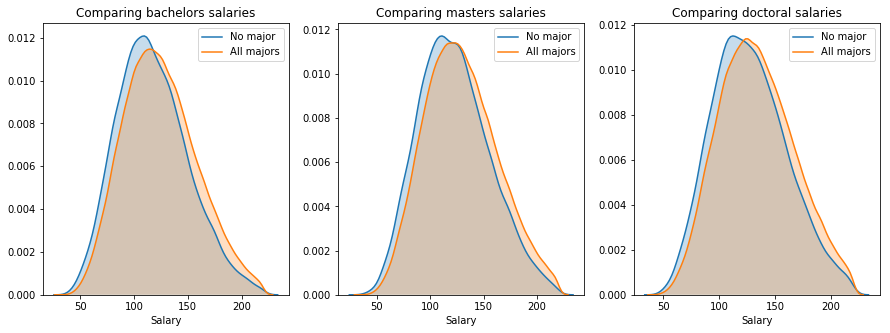

In [49]:
college = ['BACHELORS', 'MASTERS', 'DOCTORAL']

fig, ax = plt.subplots(1, len(college), figsize=(15,5))

for i, degree in enumerate(college):
    sns.kdeplot(major_none[major_none.degree==degree].salary, shade=True, label="No major", ax=ax[i])
    sns.kdeplot(train_merged[train_merged.degree==degree].salary, shade=True, label="All majors", ax=ax[i])
    ax[i].set_title(f'Comparing {degree.lower()} salaries')
    ax[i].set_xlabel('Salary')

Each time a major is listed as NONE, the salary distribution shifts slightly lower.

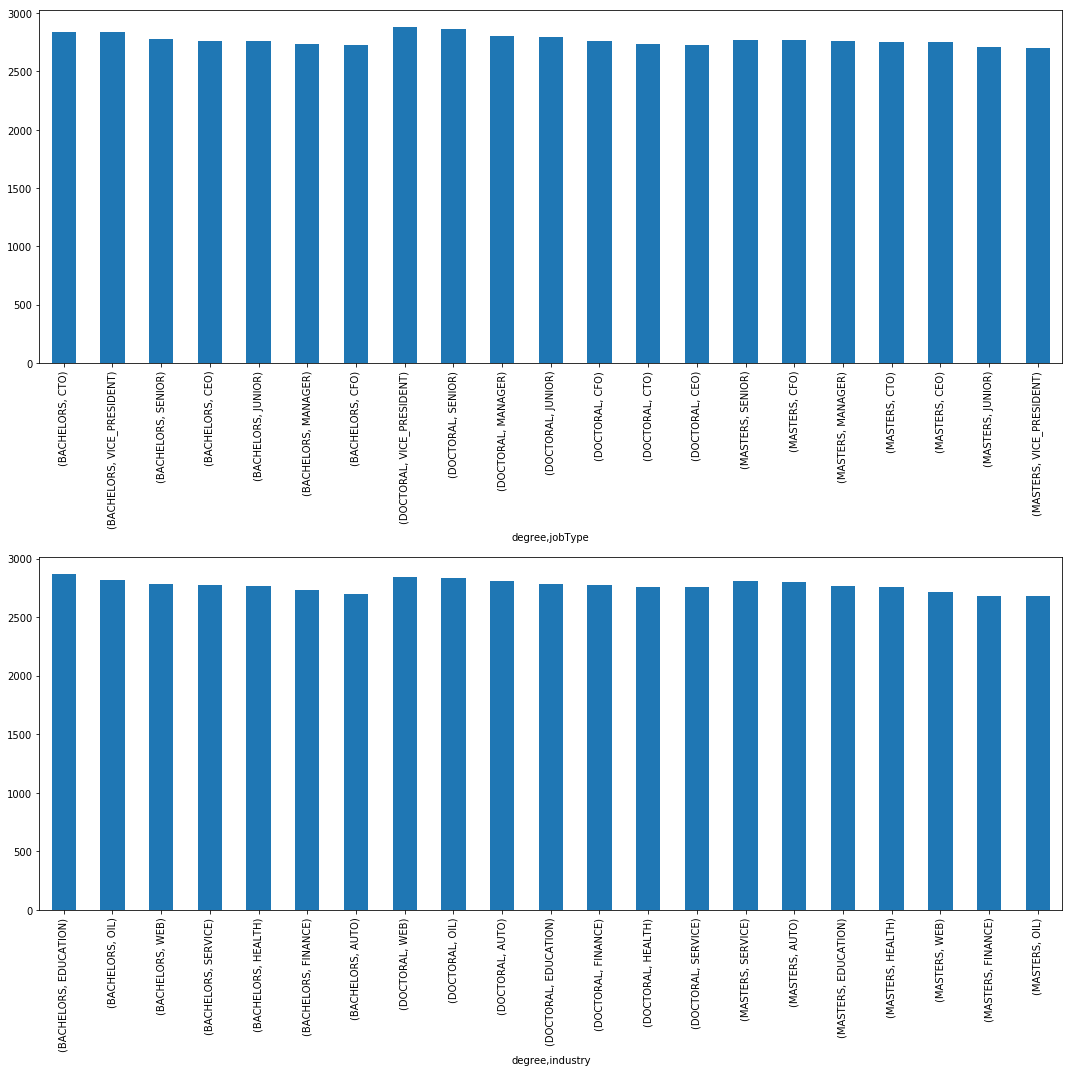

In [68]:
college_noMajor = major_none[major_none.degree.isin(college)]
fig, ax = plt.subplots(len(categorical_cols)-2, figsize=(15, 15))
plot_num = 0
for i, col in enumerate(categorical_cols):
    if col != 'degree' and col != 'major':
        college_noMajor.groupby('degree')[col].value_counts().plot.bar(ax=ax[plot_num])
        plot_num+=1
plt.tight_layout()

There seems to be an even spread of major *NONE* between the industries and job types. I do not believe I will be obtaining any new information from major *NONE* at this point, so I will move onto the next feature I want to explore.

#### Exploring the Data: JobType JANITOR

Number of Outliers above Q3: 1365
Number of Outliers below Q1: 0
Upper bound for salary outliers: 137.0


count    124971.000000
mean         70.813045
std          24.643021
min          17.000000
25%          52.000000
50%          68.000000
75%          86.000000
max         189.000000
Name: salary, dtype: float64

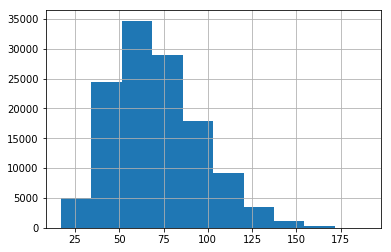

In [69]:
train_merged[train_merged.jobType=='JANITOR'].salary.hist()


lower, upper = find_outliers(train_merged[train_merged.jobType=='JANITOR'].salary)

upper_mask = (train_merged.salary > upper) & \
                (train_merged.jobType=='JANITOR')

lower_mask = (train_merged.salary < lower) & \
                (train_merged.jobType=='JANITOR')

print(f'Number of Outliers above Q3: {train_merged[upper_mask].shape[0]}')
print(f'Number of Outliers below Q1: {train_merged[lower_mask].shape[0]}')
print(f'Upper bound for salary outliers: {upper}')

train_merged[train_merged.jobType=='JANITOR'].salary.describe()

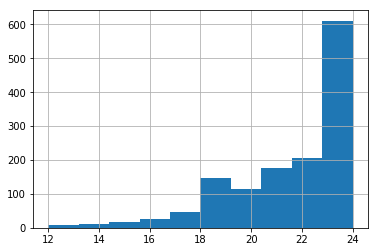

In [70]:
train_merged[upper_mask].yearsExperience.hist()

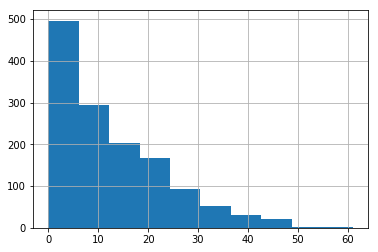

In [71]:
train_merged[upper_mask].milesFromMetropolis.hist()

After investigating the upper bound of janitorial staff, the higher salaries generally occur in cities and are for people who have an incredible amount of experience. This does make some sense after reviewing the pay scale of custodial staff from New York public schools. But, even the cases where this occurred only had salaries of roughly $125k a year at most. With this being the case combined with the fact that the outliers only make up a fraction of a percent of the total data, I will be dropping all statistical outliers for the JANITOR jobType. I'm also willing to accept that some of these could be typos with an added 1 at the front.

In [73]:
# Removing Janitor outliers
train_merged = train_merged[~upper_mask]

In [74]:
train_merged.shape

(991513, 7)

#### Exploring Data: JobType CEO

Number of Outliers above Q3: 0
Number of Outliers below Q1: 0
Upper bound for salary outliers: 234.0
Lower bound for salary outliers: 50.0


count    121551.000000
mean        142.905398
std          31.430927
min          55.000000
25%         119.000000
50%         141.000000
75%         165.000000
max         220.000000
Name: salary, dtype: float64

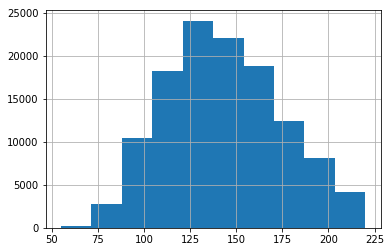

In [76]:
train_merged[train_merged.jobType=='CEO'].salary.hist()


lower, upper = find_outliers(train_merged[train_merged.jobType=='CEO'].salary)

upper_mask = (train_merged.salary > upper) & \
                (train_merged.jobType=='CEO')

lower_mask = (train_merged.salary < lower) & \
                (train_merged.jobType=='CEO')

print(f'Number of Outliers above Q3: {train_merged[upper_mask].shape[0]}')
print(f'Number of Outliers below Q1: {train_merged[lower_mask].shape[0]}')
print(f'Upper bound for salary outliers: {upper}')
print(f'Lower bound for salary outliers: {lower}')

train_merged[train_merged.jobType=='CEO'].salary.describe()

There doesn't seem to be any statistical outliers on the low end, but I do want to investigate why a CEO might be making less than $80k. There are some CEOs who elect to make less money, and I would count those as outliers. I want to see if there might be an exploitable pattern that explains why a CEO would make less.

In [77]:
low_salary_ceo = train_merged[(train_merged.salary < 80)&(train_merged.jobType=='CEO')].copy()

for col in categorical_cols:
    print()
    print(col)
    print(low_salary_ceo[col].value_counts())


jobType
CEO    1032
Name: jobType, dtype: int64

degree
NONE           609
HIGH_SCHOOL    314
BACHELORS       73
MASTERS         29
DOCTORAL         7
Name: degree, dtype: int64

major
NONE           953
BIOLOGY         22
LITERATURE      16
CHEMISTRY       14
PHYSICS         10
MATH             5
BUSINESS         5
COMPSCI          4
ENGINEERING      3
Name: major, dtype: int64

industry
EDUCATION    483
SERVICE      313
AUTO         141
HEALTH        57
WEB           31
OIL            5
FINANCE        2
Name: industry, dtype: int64


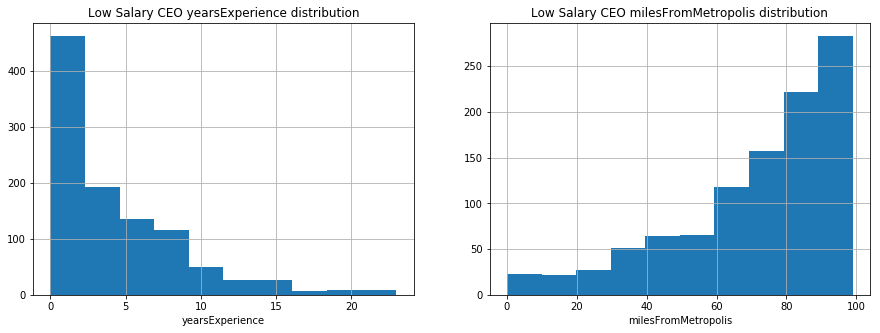

In [78]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

numerical_cols = ['yearsExperience', 'milesFromMetropolis']

for i, col in enumerate(numerical_cols):
    low_salary_ceo[col].hist(ax=ax[i])
    ax[i].set_xlabel(col)
    ax[i].set_title(f'Low Salary CEO {col} distribution')

It is quite clear that lower paid CEOs have both lower education thresholds and lower experience thresholds. I'll try to quantify their correlation below, then I'll see if the correlation remains with the entire dataset.

In [79]:
def if_college(df):
    if df.degree=='NONE' or df.degree=='HIGH_SCHOOL':
        return 0
    else:
        return 1
low_salary_ceo['college'] = low_salary_ceo.apply(if_college, axis=1).copy()

experience_bins = [-1, 3, 7, 100]
labels = [0, 1, 2]
low_salary_ceo['ExperienceLevel'] = pd.cut(low_salary_ceo.yearsExperience, bins=experience_bins, labels=labels).copy()

def is_grad_types(df):
    if df.college==0:
        if df.ExperienceLevel==0:
            return 'No College, Inexperienced'
        elif df.ExperienceLevel==1:
            return 'No College, Some Real Experience'
        else:
            return 'No College, Real World Experienced'
    else:
        if df.ExperienceLevel==0:
            return 'Recent Grad'
        elif df.ExperienceLevel==1:
            return 'Some Experience Grad'
        else:
            return 'Experienced Grad'


        
low_salary_ceo['Grad_Types'] = low_salary_ceo.apply(is_grad_types, axis=1).copy()

Note: I did no such discovery in my decision to bin the *yearsExperience* in this way.

In [80]:
low_salary_ceo['Grad_Types'].value_counts() / low_salary_ceo.shape[0]

No College, Inexperienced             0.456395
No College, Some Real Experience      0.248062
No College, Real World Experienced    0.189922
Recent Grad                           0.081395
Some Experience Grad                  0.019380
Experienced Grad                      0.004845
Name: Grad_Types, dtype: float64

A vast majority come from people who have low salaries for CEOs don't have any college background. I want to see if there is any trend for CEOs that make a lot of money. 

In [82]:
high_salary_ceo = train_merged[(train_merged.jobType=='CEO') & (train_merged.salary>200)].copy()

high_salary_ceo['college'] = high_salary_ceo.apply(if_college, axis=1)

experience_bins = [-1, 3, 7, 100]
labels = [0, 1, 2]
high_salary_ceo['ExperienceLevel'] = pd.cut(high_salary_ceo.yearsExperience, bins=experience_bins, labels=labels).copy()
high_salary_ceo['Grad_Types'] = high_salary_ceo.apply(is_grad_types, axis=1)

high_salary_ceo['Grad_Types'].value_counts() / high_salary_ceo.shape[0]

Experienced Grad                      0.749018
No College, Real World Experienced    0.187769
Some Experience Grad                  0.044324
Recent Grad                           0.018702
No College, Some Real Experience      0.000187
Name: Grad_Types, dtype: float64

There is an overwhelming majority of CEOs that are both educated and well experienced in the upper salary margins. I'll definitely make sure that these features are engineered into the data because a linear model might not be able to pick up on this correlation.

I want to check to see how the Random Forest Regressor ranks it with respect to the rest of the features.

In [83]:
from sklearn.ensemble import RandomForestRegressor
from Preprocessing import Preprocessing

ordinal_cols = {'jobType': ['JANITOR', 'JUNIOR', 'SENIOR', 'MANAGER', 'VICE_PRESIDENT', 'CFO', 'CTO', 'CEO'],
                'degree': ['NONE', 'HIGH_SCHOOL', 'BACHELORS', 'MASTERS', 'DOCTORAL'],
                'Grad_Types': ['No College, Inexperienced', 'Recent Grad', 'No College, Some Real Experience', 
                               'Some Experience Grad', 'No College, Real World Experienced', 'Experienced Grad']
               }

train_merged['college'] = train_merged.apply(if_college, axis=1).copy()

experience_bins = [-1, 3, 7, 100]
labels = [0, 1, 2]
train_merged['ExperienceLevel'] = pd.cut(train_merged.yearsExperience, bins=experience_bins, labels=labels).astype(int).copy()
train_merged['Grad_Types'] = train_merged.apply(is_grad_types, axis=1).copy()

target = ['salary']
features = [x for x in train_merged.columns if x not in target]

p = Preprocessing(ordinal_cols=ordinal_cols)
baseline_features = p.fit_transform(train_merged.loc[:, features])

#To see if features can beat out just random noise
baseline_features['noise'] = np.random.randint(2, size=baseline_features.shape[0])

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(baseline_features, train_merged[target])

In [86]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)

rf.fit(X_train, y_train.values.ravel())

y_pred = rf.predict(X_test)

importance = rf.feature_importances_

In [87]:
important = pd.DataFrame({'Importance': importance, 
                          'Feature': baseline_features.columns
                         }
                        )

random = important.loc[(important.Feature=='noise'), 'Importance'].values[0]

important = important[important.Importance >= random].sort_values('Importance', ascending=False)

Text(0.5, 1.0, 'Features More Important than Noise')

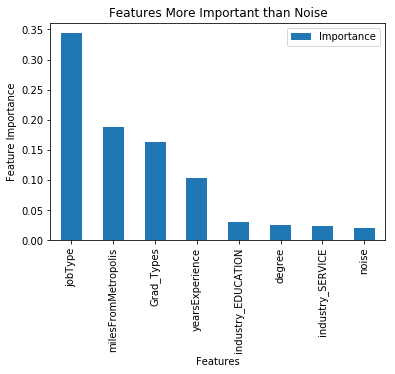

In [88]:
ax = important.plot.bar(x='Feature', y='Importance')

ax.set_ylabel('Feature Importance')
ax.set_xlabel('Features')
ax.set_title('Features More Important than Noise')

The naive binning that I did for *yearsExperience* combined with whether the job required a college degree made a feature that was only behind *jobType* and *milesFromMetropolis* in importance. I need to perform EDA to see whether there could be a better way to split *yearsExperience*

#### Exploring the Data: Numerical Columns

In [91]:
# I'll be focusing on the base features for this analysis
train_merged.drop(['college', 'ExperienceLevel', 'Grad_Types'], axis=1, inplace=True)

In [114]:
numeric_cols = [x for x in train_merged.columns if x not in categorical_cols]
print(numeric_cols)

['salary', 'yearsExperience', 'milesFromMetropolis']


Text(0.5, 1.0, 'Numerical Values Correlation Heatmap')

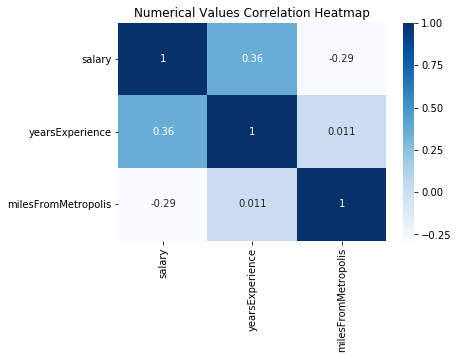

In [115]:
import seaborn as sns
ax = sns.heatmap(train_merged[numeric_cols].corr(), annot=True, cmap='Blues')
ax.set_title('Numerical Values Correlation Heatmap')

There is a somewhat significant positive correlation between *yearsExperience* and *salary*, and a just as strong negative correlation between *milesFromMetropolis* and *salary*. As the years of experience necessary for the job increases, the salary for the position increases. As the job moves farther away from a city, the salary for the position decreases. Both of these results are rather intuitive.

#### Exploring the Data: Numerical Columns, milesFromMetropolis

In [95]:
metro = train_merged[['salary', 'milesFromMetropolis']].copy()
metro.head()

,salary,milesFromMetropolis
jobId,,
JOB1362684407687,130,83
JOB1362684407688,101,73
JOB1362684407689,137,38
JOB1362684407690,142,17
JOB1362684407691,163,16


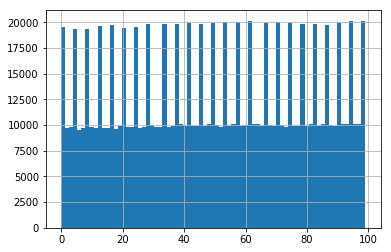

In [96]:
ax = metro.milesFromMetropolis.hist(bins=75)

The distribution of distances appears to be constant. I want to break down the salaries into 6 bins and see how the *milesFromMetropolis* distributions vary based on salary.

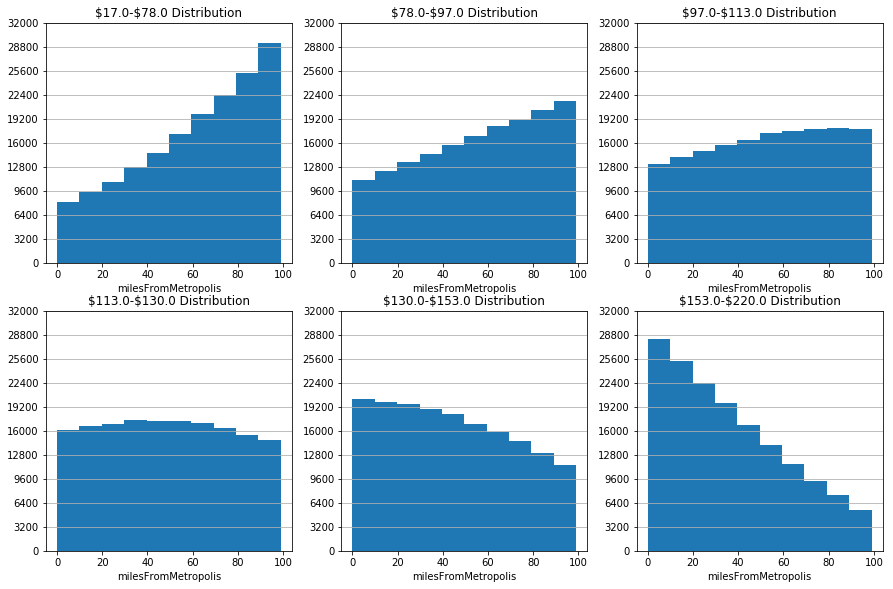

In [97]:
from math import ceil

num_bins = 6
salary_bins = [metro.salary.quantile(x/(num_bins)) for x in range(num_bins+1)]
labels = [f'\${salary_bins[x]}-\${salary_bins[x+1]}' for x in range(len(salary_bins)-1)]

metro['Salary_Binned'] = pd.cut(metro['salary'].copy(), bins=salary_bins, labels=labels)

num_cols = 3
num_rows = ceil(len(salary_bins)/num_cols)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

holder = []

for i, ax in enumerate(ax.flatten()):
    if i < len(labels):
        ax.hist(metro[metro.Salary_Binned==labels[i]].milesFromMetropolis, histtype='bar')
        ax.grid(axis='y')
        ax.set_ylim(0, 32000)
        ax.set_yticks(np.linspace(0, 32000, 11))
        ax.set_title(f'{labels[i]} Distribution')
        ax.set_xlabel('milesFromMetropolis')
    else:
        fig.delaxes(ax)

As we can see, there is an obvious negative correlation between salary and milesFromMetropolis. There doesn't seem to be anything odd in these distributions, but, I might want to eventually look into the range $\$$114-$\$$131 to see if there is any way I could make more distinctive information because the distance seems to be almost uniform over that range.

#### Exploring the Data: Numerical Columns, yearsExperience

I've already seen that *yearsExperience* pairs well with *degree* to make predictions on edge cases of salary. I want to further explore the *yearsExperience* distribution to see if I can find anything interesting as well as make sure that I'm grouping the *yearsExperience* column properly.

Text(0.5, 1.0, 'Histogram of yearsExperience illustrating the Binning')

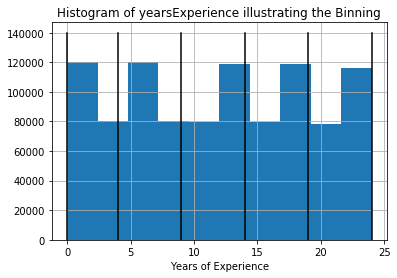

In [98]:
experience = train_merged.loc[:, ['salary', 'yearsExperience']].copy()

ax = experience.yearsExperience.hist()
experience['experienceBinned'], bins = pd.qcut(experience.yearsExperience, 5, retbins=True)


for i in bins:
    n = 1000
    y = np.linspace(0, 140000, n)
    x = np.full(n, i)
    
    ax.plot(x, y, color='k')

ax.set_xlabel('Years of Experience')
ax.set_title('Histogram of yearsExperience illustrating the Binning')

It seems quite clear that there are 5 distinct bins of experience that a person could fall into rather than the 3 bins I guessed with earlier. This should make the engineered feature above more useful, especially for linear models which have a difficult time noticing patterns in combinations of features.

(-0.001, 4.0]
Mean: 96.00

(4.0, 9.0]
Mean: 105.85

(9.0, 14.0]
Mean: 115.80

(14.0, 19.0]
Mean: 125.12

(19.0, 24.0]
Mean: 133.77



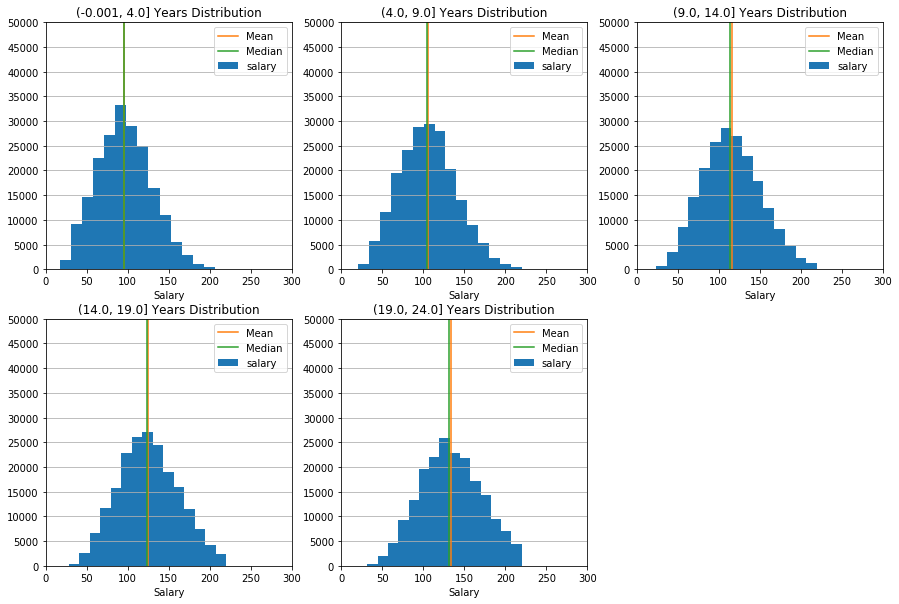

In [100]:
from math import ceil
num_cols = 3
num_rows = ceil(len(bins)/num_cols)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

labels = experience.experienceBinned.unique().sort_values()

for i, ax in enumerate(ax.flatten()):
    if i < len(labels):
        ylim = 50000
        data = experience[experience['experienceBinned']==labels[i]].salary
        ax.hist(data, histtype='bar', bins=15)
        ax.grid(axis='y')
        ax.set_ylim(0, ylim)
        ax.set_yticks(np.linspace(0, 50000, 11))
        ax.set_title(f'{labels[i]} Years Distribution')
        ax.set_xlim(0, 300)
        ax.set_xlabel('Salary')
        
        y = np.linspace(0, ylim, 1000)
        x_mean = np.full(1000, data.mean())
        x_median = np.full(1000, data.median())
        
        ax.plot(x_mean, y, label='Mean')
        ax.plot(x_median, y, label='Median')
        ax.legend()
        
        print(labels[i])
        print(f'Mean: {x_mean[0]:.2f}')
        print()
    else:
        fig.delaxes(ax)
    

Each of the bins have a rather nice distribution of salary. It is also clear that the salaries increase when the years of experience increases as seen with the drastic increase in mean over the bins.

I also wanted to take a look at the distribution of *yearsExperience* for the more entry-level jobType of JUNIOR. Any JUNIOR position is generally meant for applicants earlier on in their careers. In my own job search, junior level positions have asked for up to 5 years of experience in samples of thousands of job listings. I am willing to say that any statistical outliers on the higher end of the distribution are typos and should be removed from the data.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e25f90860>,
      dtype=object)

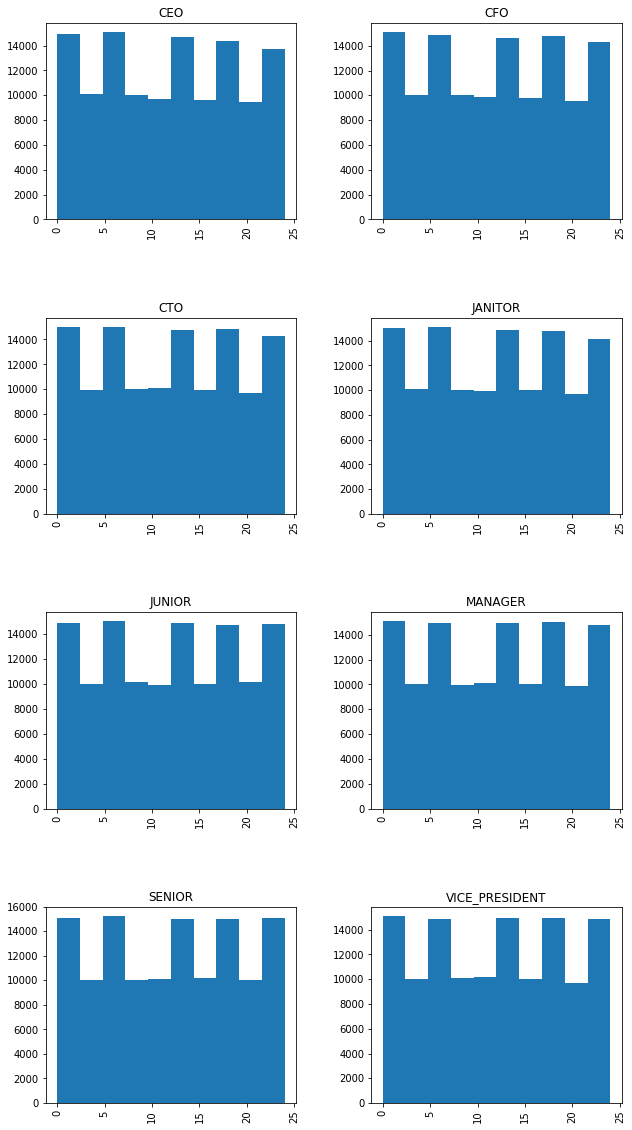

In [101]:
fig, ax = plt.subplots(train_merged.jobType.nunique() // 2, 2, figsize=(10, 20))
train_merged.yearsExperience.hist(by=train_merged.jobType, ax=ax)

They all have almost the exact same distribution. I cannot justify removing the non-intuitive distribution of experience seen at the JUNIOR *jobType*.

## Establishing a Baseline Outcome

I'm going to make a rather naive model using the average income of the job type as the only predictor. With the quick glance at the data I've done above, it seems that job type is the best individual predictor. I would like to show that my final model is better than just the naive approach.

I'll partition off a chunk of my data to act as the test data since none was originally given. This is so that I can train both the naive and final model on the same data.

In [102]:
train_merged.head()

,salary,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobId,,,,,,,
JOB1362684407687,130,CFO,MASTERS,MATH,HEALTH,10,83
JOB1362684407688,101,CEO,HIGH_SCHOOL,NONE,WEB,3,73
JOB1362684407689,137,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
JOB1362684407690,142,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
JOB1362684407691,163,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [103]:
from sklearn.model_selection import train_test_split
train_data_merged, test_data_merged = train_test_split(train_merged, test_size=.3, random_state=44)

I want to save these datasets externally so that I will be using the same training and test data between various notebooks

In [104]:
%%bash
rm -r ./model_validation_data

mkdir ./model_validation_data

In [105]:
train_data_merged.to_csv('./model_validation_data/train.csv')
test_data_merged.to_csv('./model_validation_data/test.csv')

In [106]:
# Creating a naive model on the training data I have

nm = NaiveModel(agg_col='jobType', target_col='salary')

# Fitting the model on the train data
nm.fit(train_data_merged)

# Predicting on test data
y_pred = nm.predict(test_data_merged)
y_actual = test_data_merged['salary']

print(mean_squared_error(y_pred, y_actual))

894.9376414799021


Great! Now we have a baseline to actually see how well our model actually is at predicting. I do want to quickly check how much better this naive model is than using the mean of the entire dataset instead of taking the mean split by a grouping.

In [107]:
print(mean_squared_error(train_data_merged['salary'].mean(), y_actual))

1407.9054841393777


Ok, the naive model was much better than just trying the mean of the test data.

### Hypothesizing Solutions


Given the comparison of the Naive Model to the prediction just using the training data mean as well as the variations we saw in the grouped means we know that the categorical values will definitely be useful in creating our model. The heatmap also showed that there was a correlation between the numerical values and the salary. More importantly, the heatmap also illustrated that *yearsExperience* and *milesFromMetropolis* had no correlation whatsoever, so we'll be able to learn information from both features independently. The only feature that looks close to useless is *major*, but the slight variation and increased dip in *NONE* as a value might help us get moree information.